In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import ascii
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightkurve as lk
from sklearn.inspection import permutation_importance
import math as m
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import LS_modular
import bls_modular
import seaborn as sns
import glob
#rf-3 specific
from astroquery.mast import Catalogs 
from sklearn.metrics import confusion_matrix, plot_confusion_matrix




/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# unique item finder

def uniquefinder(mylist):
    '''
    Function finds unique values within a list, also stats on occurance rates
    
    inputs: an array or list 
            (integers or strings)
    2 outputs: dictionary of occurances, list of unique values 
    '''
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('There are {} unique tics out of the original {}.'.format(uniques,len(mylist)),\
        '\nUse the first output dictionary', \
          'to see number of occurances for duplicates')
    return seen, uniq_tics


#useful fcn - compares lists & returns what didnt match
def returnNotMatches(a, b):
    '''
    inputs: a,b
            both lists or arrays
    outputs: not in b, not in a
            two lists
    '''
    return [[x for x in a if x not in b], [x for x in b if x not in a]] #not in b , not in a


def find_range(x, axis=0):
    return np.max(x, axis=axis) - np.min(x, axis=axis)


def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return m.floor(n * multiplier) / multiplier


def round_up(n, decimals=0): 
    multiplier = 10 ** decimals 
    return m.ceil(n * multiplier) / multiplier


# based on training set
def rf1_label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    2==Complex = "clear periodicity but complicated by multiple spots or low signal to noise";
    3== EB = "eclipsing binaries"; 
    4==Binaries = "likely eclipsing binaries too"; 
    5==Flat = "no rotational modulation"
    '''
    mydictionary = {1:'Astrophysical Signal',3:'Likely Eclipsing Binary',5:'Flat',2:'nothing',4:'nothing'}
    return(mydictionary[label])

# based on training set
def rf2_label_meanings(label):
    ''' 
    1== Periodic = "very clear periodicity in light curve"; 
    3== EB = "eclipsing binaries"; 
    '''
    mydictionary = {1:'NO transit',3:'YES transit',5:'nothing',2:'nothing',4:'nothing'}
    return(mydictionary[label])

# based on training set
def rf3_label_meanings(label):
    ''' 
    1== BAD = "my Prot doesn't match MQ's Prot within 'using_tolerance' variable value"; 
    2==Half Harmonic = "my Prot is half what MQ's is";
    3== GOOD = "my Prot matches MQ's Prot to within 'using_tolerance' variable value"; 
    '''
    mydictionary = {1:'BAD',2:'Half Harmonic',3:'GOOD',4:'nothing',5:'nothing'}
    return(mydictionary[label])

def abs_mag(m,D):
    '''
    ~converts apparent mag to absolute mag~
    args:
          m: apparent mag
          D: 1/parallax in parsecs
    RETURNS: absolute mag
    '''
    return m - 5*np.log10(D) + 5

def mas_to_parsec(mas):
    '''
    ~converts milliarcseconds(mas) to parsecs, useful b/c Gaia parallax in mas~
    args:
         mas: parallax measure in mas
    RETURNS: parallax in parsecs
    '''
    return mas * 1000

def get_D(parallax):
    '''
    ~converts parallax to distance~
    args:
        parrallax: parallax measure in mas
    RETURNS: distance
    '''
    plx = mas_to_parsec(parallax)
    return 1/plx

def slope(x1,x2,y1,y2):
    ''' 
    inputs: coordinates for 2 plotted datapoints
    returns: slope
    '''
    m = (y2 -y1) / (x2-x1)
    return (y2 -y1) / (x2-x1)

def get_b(m,x,y):
    '''
    gives y-intercept(b) for a straight line
    inputs: slope(m); point on line(x,y)
    returns: b
    '''
    b = -(m*x) + y
    return b

def plot_lc(table,fold=False):
    '''
    ~Scatter plots light curve~
    Args:
    table = dataframe with tic, sector, blsperiod; must be 20 in lenght or less
    fold = (boolean,optional) plots folded light curve instead if True
    Returns:
    scatter plot of lc
    '''
    length = len(table)
    if length >20:
        print('reduce input table to 20 targets or less')
    else:
        if fold == False:
            f, ax = plt.subplots(length,1,figsize=(12,length*4))
        else:
            f, ax = plt.subplots(length,1,figsize=(5,length*4))
        for i in range(length):
            sec = table['Sector'].iloc[i]
            tic = table['TIC'].iloc[i]
            if np.isnan(sec) == True:
                sector = 'S-CVZ'
                path = '/Volumes/Seagate-stars/SECONDRUN/cleaned_LightCurves/{}/lc.fits'.format(tic)
            else:
                sector = int(sec)
                path = '/Volumes/Seagate-stars/SECTORS/Sector_{}/Sec{}_cleaned/{}/lc.fits'.format(sector,sector,tic)
            blsper = table['period_bls'].iloc[i]
            file = lk.open(path)
            lc = file.FLUX
            if fold == True:
                folded = lc.fold(blsper)
                plot = ax[i].scatter(folded.time,folded.flux,s=.2)
                ax[i].set_title('TIC: {} Sector: {} Per: {}'.format(tic,sector,"%.3f" % blsper),fontsize=25);
            else:
                plot = ax[i].scatter(lc.time,lc.flux,s=.2)
                ax[i].set_title('TIC: {} Sector: {} Per: {}'.format(tic,sector,"%.2f" % blsper),fontsize=25);
        plt.tight_layout()

# RF-1

In [3]:
#load data

#all data
allstats = pd.read_csv('data/master_data.csv')
#training examples subset
examples = allstats[np.isnan(allstats['CLASS'])==False]
#for comparisons later
mqdata = pd.read_csv('data/mcquillan_sample.csv')
#remaining subset
unseen_targets = allstats[np.isnan(allstats['CLASS'])==True]


print('total:{}, training set: {}, remaining data: {}'.format(len(allstats),len(examples),len(unseen_targets)))

total:26134, training set: 291, remaining data: 25843


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (19,99,125) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## select relevant class examples for RF-1

#drop high teff CVZ examples--done for all RFs 1,2,3
examples = examples[examples['Teff']<=6500] #drops none b/c think did that in RF_trainingexmpales_final
#only keep CVZ periodic(1) or flat(5) labels for RF1
rf1_features = examples[(examples['CLASS']==1) | (examples['CLASS']==5)] #lost 66 but its ok, proceed

# print(list(rf1_features.columns)) #easier way to see all columns
rf1_features.describe()

,TIC,period_bls,power_bls,depth_bls,dur_bls,tt_bls,Sector,rvar,ls-1,ls-2,...,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,GAIA_AbsMag,CLASS,TOTsecs,LS_correct
count,2.250000e+02,225.000000,225.000000,225.000000,225.000000,225.000000,77.000000,225.000000,225.000000,225.000000,...,225.000000,225.000000,225.000000,225.000000,225.000000,2.250000e+02,225.000000,225.000000,148.000000,90.000000
mean,1.349150e+08,8.845480,21313.835556,0.001460,0.203244,4.221437,14.272727,1207.444225,7.402125,6.842411,...,-27.854876,0.043609,0.048326,0.982222,0.004444,4.492783e+08,35.826172,2.493333,11.898649,0.755556
std,6.544888e+07,7.500087,18983.280979,0.012104,0.062896,5.151291,0.448282,4566.534648,7.074506,6.023602,...,59.059993,0.067486,0.079413,0.188140,0.066667,1.522573e+08,2.456239,1.939072,0.855076,0.432165
min,1.589229e+07,0.300000,0.000000,0.000007,0.010000,0.001870,14.000000,0.000562,0.501684,0.500644,...,-78.763716,0.013132,0.014128,-1.000000,0.000000,1.350812e+08,31.635939,1.000000,10.000000,0.000000
25%,1.405974e+08,0.304516,75.000000,0.000065,0.160000,0.161000,14.000000,0.006594,3.572485,2.971189,...,-73.357883,0.020544,0.022532,1.000000,0.000000,4.060409e+08,34.138651,1.000000,11.000000,1.000000
50%,1.416076e+08,12.603532,30535.000000,0.000153,0.160000,1.712000,14.000000,0.018215,5.815755,5.468173,...,-63.182837,0.024714,0.026706,1.000000,0.000000,5.288348e+08,35.136811,1.000000,12.000000,1.000000
75%,1.595027e+08,15.041281,36950.000000,0.000371,0.290000,6.560000,15.000000,31.628241,9.583240,8.748268,...,39.848130,0.034393,0.035229,1.000000,0.000000,5.569529e+08,36.803658,5.000000,12.000000,1.000000
max,3.491544e+08,19.992400,49979.000000,0.180532,0.290000,19.760000,15.000000,52346.624707,49.558430,42.797165,...,80.450725,0.503858,0.634045,1.000000,1.000000,5.888265e+08,42.862185,5.000000,13.000000,1.000000


In [5]:
## select features to use

rf1_features_list = ['rvar',
                 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3',
                 'Vmag','Tmag','CLASS', 'RA_orig', 'Dec_orig',]
#select features
rf1_short_features_nans = rf1_features[rf1_features_list]
#remove any nans in the final features
rf1_short_features = rf1_short_features_nans.dropna()
#see effect of features on number of examples
rf1_nan_exs_loss = len(rf1_short_features_nans) - len(rf1_short_features)
print('{} examples lost with these features'.format(rf1_nan_exs_loss))

#check final distribution for possible problems
rf1_short_features.describe(include='all')

0 examples lost with these features


,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,Vmag,Tmag,CLASS,RA_orig,Dec_orig
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,1207.444225,7.402125,6.842411,6.068143,0.224655,0.080858,0.045427,11.207930,10.173231,2.493333,147.058422,-27.854876
std,4566.534648,7.074506,6.023602,5.793043,0.287842,0.101062,0.053562,2.671231,2.128541,1.939072,90.425744,59.059993
min,0.000562,0.501684,0.500644,0.502642,0.000213,0.000179,0.000178,4.009980,3.518000,1.000000,67.064048,-78.763716
25%,0.006594,3.572485,2.971189,2.873480,0.002860,0.002089,0.001931,9.592000,8.996400,1.000000,75.304408,-73.357883
50%,0.018215,5.815755,5.468173,4.782586,0.075667,0.033185,0.023101,11.044000,10.388700,1.000000,96.930512,-63.182837
75%,31.628241,9.583240,8.748268,6.870347,0.385852,0.137367,0.080218,12.291000,11.374200,5.000000,232.941352,39.848130
max,52346.624707,49.558430,42.797165,46.673108,0.993360,0.524464,0.249504,17.460000,15.087900,5.000000,325.679016,80.450725


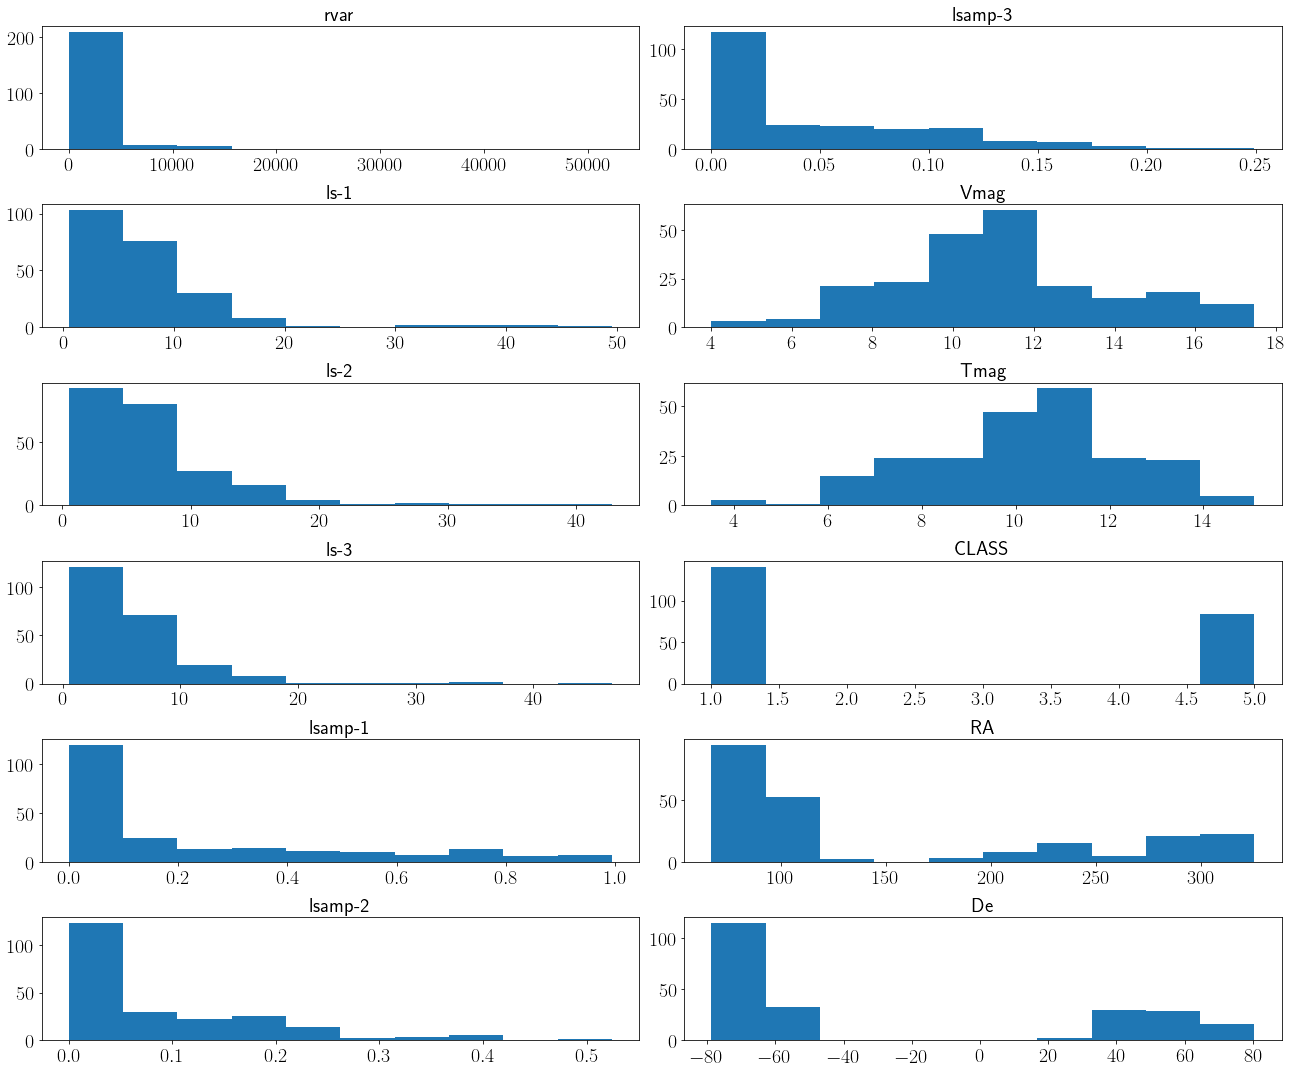

In [6]:
## explore distribution of training examples' features

f, ax = plt.subplots(6,2,figsize=(18,15))
for count,col in enumerate(list(rf1_short_features.columns)):
    
    if count <6: #count % 2 ==False: #even
        ax[count,0].hist(rf1_short_features[col])
        if col[-4::] == 'orig':
            colname = col[0:2]
        else:
            colname = col
        ax[count,0].set_title(colname,fontsize=20)
    else: #odd
        ax[count-6,1].hist(rf1_short_features[col])
        if col[-4::] == 'orig':
            colname = col[0:2]
        else:
            colname = col
        ax[count-6,1].set_title(colname,fontsize=20)
plt.tight_layout()

In [7]:
## summarize Final info used in RF-1

#inject random number as feature
np.random.seed(seed = 11)
rf1_short_features['random'] = np.random.random(size = len(rf1_short_features))
#split training labels from data
rf1_final_labels = rf1_short_features['CLASS'].to_numpy()
rf1_final_features = rf1_short_features.drop(columns=['CLASS'])
# print('verify these match {} = {}\n'.format(len(final_labels),len(final_features)))
rf1_perio = len(rf1_final_labels[rf1_final_labels==1])
rf1_flats = len(rf1_final_labels[rf1_final_labels==5])

# print final number of training examples and which features used
print('RF-1\n----------------------------\n')
print('{} Features Used. \nThey are {}'.format(len(rf1_final_features.columns),list(rf1_final_features.columns)))
print('{} Training Examples Used.'.format(len(rf1_final_features)))
print('{} periodic exs. {} flat exs.'.format(rf1_perio,rf1_flats))
print('\n------------------------------- \nUse "rf1_final_labels" & "rf1_final_features"')

RF-1
----------------------------

12 Features Used. 
They are ['rvar', 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3', 'Vmag', 'Tmag', 'RA_orig', 'Dec_orig', 'random']
225 Training Examples Used.
141 periodic exs. 84 flat exs.

------------------------------- 
Use "rf1_final_labels" & "rf1_final_features"


In [8]:
## RF-1 model

#set variable for feature data
rf1_X = rf1_final_features
#set variable for correct labels
rf1_y = rf1_final_labels
#split data into test and training set
X_train, test_X, y_train, test_y = train_test_split(rf1_X, rf1_y, random_state = 11)

#define random forest model
rf1_model = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf1_model.fit(X_train, y_train)

# print accuracy scores
print('Test Set Accuracy:',rf1_model.score(test_X,test_y))  
print('Training Set Accuracy:', rf1_model.score(X_train,y_train))
print('Out of the Box Accuracy:',rf1_model.oob_score_)

Test Set Accuracy: 0.9649122807017544
Training Set Accuracy: 0.9761904761904762
Out of the Box Accuracy: 0.9166666666666666


In [9]:
## Cross Validataion of RF-1

#set variable for feature data
rf1_X_CV = rf1_final_features.copy()
#set variable for correct labels
rf1_y_CV = rf1_final_labels
#input: features,labels
# divide data to train(80),test(19),validate(1)--why do i still have a test-thats the loo
rf1_CVpredictions = [] #collect predictions for loo - can add to df as a column b/c loo goes in order
for count,idx in enumerate(rf1_X_CV.index):
    ##get validation set--aka the one left out
    loo_x = rf1_X_CV.iloc[count]
    loo_y = rf1_y_CV[count]
    ##remove validation data from features/labels ---aka this is the training data
    x_after_loo = rf1_X_CV.drop(index = idx)
    y_after_loo = np.delete(rf1_y_CV, count)
    ##split remaining data into training & testing
    x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x_after_loo, y_after_loo, random_state = 11)
    ##setup model
    rf1_model_CV = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
    ##fit model with train data
    rf1_model_CV.fit(x_train_cv, y_train_cv)
    ##make loo into a df b/c model is picky b/c its only one example
    mydic = {'rvar':loo_x['rvar'],'ls-1':loo_x['ls-1'],'ls-2':loo_x['ls-2'],
            'ls-3':loo_x['ls-3'],'lsamp-1':loo_x['lsamp-1'],'lsamp-2':loo_x['lsamp-2'],'lsamp-3':loo_x['lsamp-3'],
            'Vmag':loo_x['Vmag'],'Tmag':loo_x['Tmag'],'random':loo_x['random'],'RA_orig':loo_x['RA_orig'],'Dec_orig':loo_x['Dec_orig']}
    loo_x_df = pd.DataFrame(mydic,index=[0])
    ##predict for validate target
    validation_prediction = rf1_model_CV.predict(loo_x_df) 
    ##save predictions
    rf1_CVpredictions.append(validation_prediction[0])
    
##add to df
rf1_X_CV['prediction'] = rf1_CVpredictions
rf1_X_CV['truth'] = rf1_y_CV

#CV_LOO accuracy
rf1_correct = 0
for count,val in enumerate(rf1_X_CV['prediction'].to_numpy()):
    truth = rf1_X_CV['truth'].iloc[count]
    if val == truth:
        rf1_correct += 1
    else:
        pass    
print((rf1_correct/len(rf1_X_CV)) *100, 'accurate for cross validation')

93.33333333333333 accurate for cross validation


No handles with labels found to put in legend.


lsamp-1     0.272961
lsamp-2     0.221754
lsamp-3     0.208154
RA_orig     0.063296
ls-1        0.040211
Vmag        0.037942
rvar        0.035446
Dec_orig    0.030307
Tmag        0.027098
ls-2        0.026612
ls-3        0.024550
random      0.011670
dtype: float64


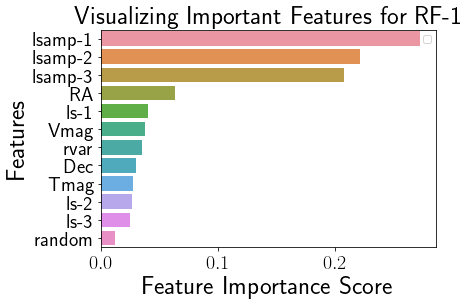

In [10]:
## feature importance

#stsci ds (DSMO) way
rf1_feature_imp = pd.Series(rf1_model.feature_importances_,index=list(rf1_X.columns)).sort_values(ascending=False)
print(rf1_feature_imp)
#fix feature names so plot can avoid latex issues
rf1_imps=[]
for i in rf1_feature_imp.index:
    if i[-4::]=='orig':
        i = i.split("_")
        i = i[0]
    else:
        i = i
    rf1_imps.append(i)
#create a bar plot
sns.barplot(x=rf1_feature_imp, y=rf1_imps) #feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for RF-1",fontsize=25)
plt.legend()
plt.show()

In [11]:
## make predicitons for all data (even training)

#inject random number
np.random.seed(seed = 11)
allstats['random'] = np.random.random(size = len(allstats))
#select only columns used as features
rf1_allstats_features = allstats[list(rf1_final_features.columns)]
#drop nans
all_forRF1 = rf1_allstats_features.dropna()
rf1_nan_loss = len(rf1_allstats_features) - len(all_forRF1)
print('due to nan features lost: {} targets'.format(rf1_nan_loss))
#make predictions
rf1_predictions = rf1_model.predict(all_forRF1)
#drop random column b/c not needed

#add predicted class to df
all_forRF1['RF1predict_class'] = rf1_predictions
#merge those predictions with master_data & fill in nans if no predictions (b/c of nan feature values)
RF1_master_data = allstats.join(all_forRF1['RF1predict_class'])
RF1_master_data

due to nan features lost: 140 targets


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,TIC,period_bls,power_bls,depth_bls,dur_bls,tt_bls,Sector,rvar,ls-1,ls-2,...,e_Dec_orig,raddflag,wdflag,objID,GAIA_AbsMag,CLASS,TOTsecs,LS_correct,random,RF1predict_class
0,7582633,0.301299,24.0,0.000203,0.29,0.166,14.0,75.968750,14.495760,8.173459,...,0.022591,1.0,0,185853561,34.943274,NaN,NaN,NaN,0.180270,1.0
1,7582634,0.301299,24.0,0.000365,0.29,0.166,14.0,74.171191,7.750743,3.649676,...,0.032185,1.0,0,185853562,35.598986,NaN,NaN,NaN,0.019475,5.0
2,7583285,0.302712,50.0,0.000313,0.29,0.167,14.0,38.014453,12.708452,7.928387,...,0.020469,1.0,0,185853911,35.449110,NaN,NaN,NaN,0.463219,5.0
3,7585322,0.301950,36.0,0.000090,0.29,0.153,14.0,93.561914,5.732579,10.313173,...,0.029643,1.0,0,186298939,33.472187,NaN,NaN,NaN,0.724934,5.0
4,7619197,0.300486,9.0,0.000062,0.29,0.153,14.0,138.729297,3.971079,3.035660,...,0.025357,1.0,0,186751232,33.312785,NaN,NaN,NaN,0.420204,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26129,349152048,13.595352,33145.0,0.000076,0.16,2.528,NaN,0.014203,0.667290,0.665706,...,0.020628,1.0,0,586307677,33.616790,1.0,12.0,1.0,0.764213,1.0
26130,349154435,4.432229,9032.0,0.009053,0.16,3.008,NaN,0.014492,4.547054,2.216561,...,0.019333,1.0,0,586309625,34.188440,1.0,13.0,1.0,0.634079,1.0
26131,364302118,1.345427,909.0,0.007843,0.16,1.104,NaN,0.035577,0.672685,1.346318,...,0.398656,1.0,0,536907677,32.880060,3.0,12.0,NaN,0.314434,1.0
26132,382069441,16.470489,40711.0,0.002633,0.16,1.792,NaN,0.035260,5.477068,5.594156,...,0.022839,1.0,0,539669002,36.012735,3.0,12.0,NaN,0.337377,1.0


In [12]:
## summarize RF-1 results proceeding to RF-2

rf1_good_allpredictions = RF1_master_data[RF1_master_data['RF1predict_class']==1.0] #periodic
rf1_bad_allpredictions = RF1_master_data[RF1_master_data['RF1predict_class']==5.0] #flats
rf1_good_unseenpredictions = RF1_master_data[(np.isnan(RF1_master_data['CLASS'])==True) & (RF1_master_data['RF1predict_class']==1.0)]
rf1_bad_unseenpredictions = RF1_master_data[(np.isnan(RF1_master_data['CLASS'])==True) & (RF1_master_data['RF1predict_class']==5.0)]
training_total = RF1_master_data[np.isnan(RF1_master_data['CLASS'])==False]
unseen_total = RF1_master_data[np.isnan(RF1_master_data['CLASS'])==True]

print('predictions from RF1 for ALL data (including cvz/sec1415 training stars):')
print('PERIODIC:',len(rf1_good_allpredictions),'out of', len(RF1_master_data) )
print('FLAT:',len(rf1_bad_allpredictions),'out of', len(RF1_master_data) )
print('\npredictions from RF-1 for UNSEEN data (no training examples included whether used or not in training):')
print('PERIODIC:',len(rf1_good_unseenpredictions),'out of', len(unseen_total) - rf1_nan_loss )
print('FLAT:',len(rf1_bad_unseenpredictions),'out of', len(unseen_total) - rf1_nan_loss )

print('\n{} stars proceed to RF-2'.format(len(rf1_good_unseenpredictions)))

predictions from RF1 for ALL data (including cvz/sec1415 training stars):
PERIODIC: 8361 out of 26134
FLAT: 17633 out of 26134

predictions from RF-1 for UNSEEN data (no training examples included whether used or not in training):
PERIODIC: 8166 out of 25703
FLAT: 17537 out of 25703

8166 stars proceed to RF-2


# RF-2 ---------------------------------------------------------

In [13]:
## carry over RF1 results -- variable name change

unseen_RF1 = rf1_good_unseenpredictions
#continue to use 'examples', 'allstats','mqdata' variables opened at start of rf1


In [14]:
## select relevant class training examples & explore features

#only keep periodic(1) or EBs(3) labels
rf2_features = examples[(examples['CLASS']==1) | (examples['CLASS']==3)]

#how many examples per class
print('{} Training Examples:'.format(len(rf2_features)))
print('{} Periodic & {} Transiting\n'.format(len(rf2_features[rf2_features['CLASS']==1]), len(rf2_features[rf2_features['CLASS']==3])))

# print(list(rf2_features.columns)) #easier way to see all column names
pd.set_option('display.max_columns', None) #show all columns
rf2_features.describe()#include='all')

167 Training Examples:
141 Periodic & 26 Transiting



,TIC,period_bls,power_bls,depth_bls,dur_bls,tt_bls,Sector,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,version,HIP,GAIA,APASS,KIC,ra,dec,pmRA,e_pmRA,pmDEC,e_pmDEC,plx,e_plx,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,priority,eneg_EBV,epos_EBV,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,eneg_Teff,epos_Teff,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,GAIA_AbsMag,CLASS,TOTsecs,LS_correct
count,1.670000e+02,167.000000,167.000000,167.000000,167.000000,167.000000,45.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.0,45.000000,1.670000e+02,1.370000e+02,8.000000e+00,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,164.000000,163.000000,167.000000,167.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,0.0,155.000000,155.000000,156.000000,156.000000,156.000000,155.000000,156.000000,125.000000,167.000000,167.000000,167.000000,167.000000,167.000000,158.000000,156.000000,154.000000,59.000000,59.000000,164.000000,154.000000,156.000000,154.000000,156.000000,154.000000,156.000000,154.000000,167.000000,158.000000,157.000000,155.000000,163.000000,163.000000,162.000000,155.000000,155.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,133.000000,152.000000,152.000000,133.000000,133.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.000000,167.000000,122.000000,90.000000
mean,1.649497e+08,8.168139,19400.401198,0.002879,0.193353,3.979049,14.466667,1607.439937,6.811878,6.153971,6.052795,0.318640,0.114573,0.064077,20190415.0,63066.688889,4.185539e+18,3.537294e+07,1.017583e+07,132.283119,-32.492420,-5.212500,0.208565,21.576081,0.228274,14.794059,0.089722,229.732842,-12.115443,191.475352,-42.197975,11.380933,0.099116,10.652637,0.040975,17.252740,0.015516,14.400740,0.002866,13.892380,0.004850,14.429960,0.010402,12.689300,0.007778,8.942108,0.028994,8.573653,0.029976,8.462263,0.027359,NaN,8.600723,0.042581,8.561417,0.024763,8.531083,0.030781,8.179583,0.204232,10.319362,0.001268,9.747003,0.019440,5357.213653,129.201404,4.381790,0.072796,-0.106386,0.067955,1.160756,0.058221,0.933247,0.118406,1.857596,0.233754,2.118517,0.097310,148.342716,1.223293,0.033495,0.005567,399.993865,0.230490,0.008473,0.005598,0.005536,0.120836,0.146970,0.063589,0.067407,0.205411,0.257846,0.083372,0.082850,0.109632,0.113969,1.237454,1.273127,122.326250,128.302571,10.851642,0.029530,9.712951,0.003526,0.940120,3.778215,3.539219,132.282981,-32.492327,0.050621,0.055735,0.976048,0.005988,4.607592e+08,35.263714,1.311377,11.729508,0.766667
std,6.875864e+07,7.445012,19037.933286,0.015978,0.059126,4.976389,0.504525,5243.006837,7.409234,6.003907,6.664354,0.287530,0.101742,0.052801,0.0,24516.595538,1.529523e+18,9.579309e+06,3.583788e+06,72.559311,57.244813,90.298607,0.729449,109.993778,0.771347,15.021656,0.279226,79.362209,29.383866,88.277494,67.535664,2.647902,0.103841,2.501085,0.059016,1.890793,0.007673,2.333136,0.002110,1.809674,0.005149,2.362521,0.006148,1.031756,0.006145,1.888438,0.036341,1.839695,0.028826,1.826880,0.035238,NaN,1.586413,0.042705,1.636554,0.013203,1.557432,0.034376,1.315756,0.153887,2.219773,0.002091,2.053515,0.164928,914.115134,18.968462,0.345564,0.028375,0.320349,0.030502,0.677398,0.034468,0.263674,0.048584,3.053451,0.189759,3.576082,0.1976

In [15]:
## finalize list of features used

rf2_features_list = ['TIC','rvar','Teff',
                 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3',
                 'power_bls', 'period_bls', 'depth_bls', 'tt_bls', 'dur_bls',
                 'Vmag','Tmag','CLASS']
#would like to use these BUT would cause a reduction in my training sample due to nans
rf2_extra_features_list = ['logg','Bmag'] #have too many nans

#select features
rf2_short_features_nans = rf2_features[rf2_features_list]
#remove any nans in the final features
rf2_short_features = rf2_short_features_nans.dropna()

#see effect of features on number of examples
rf2_nan_exs_loss = len(rf2_short_features_nans) - len(rf2_short_features)
print('{} examples lost with these features'.format(rf2_nan_exs_loss))
#check final distribution for possible problems
rf2_short_features.describe(include='all')

0 examples lost with these features


,TIC,rvar,Teff,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,power_bls,period_bls,depth_bls,tt_bls,dur_bls,Vmag,Tmag,CLASS
count,1.670000e+02,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,1.649497e+08,1607.439937,5357.213653,6.811878,6.153971,6.052795,0.318640,0.114573,0.064077,19400.401198,8.168139,0.002879,3.979049,0.193353,10.652637,9.747003,1.311377
std,6.875864e+07,5243.006837,914.115134,7.409234,6.003907,6.664354,0.287530,0.101742,0.052801,19037.933286,7.445012,0.015978,4.976389,0.059126,2.501085,2.053515,0.727301
min,1.673687e+07,0.001149,2967.000000,0.501684,0.500644,0.500600,0.000044,0.000027,0.000024,0.000000,0.300000,0.000017,0.024000,0.010000,4.009980,3.518000,1.000000
25%,1.416555e+08,0.011156,5033.685000,2.228937,1.991309,2.045673,0.073684,0.032498,0.022586,178.500000,0.312092,0.000074,0.165000,0.160000,9.207000,8.523450,1.000000
50%,1.503933e+08,0.033693,5647.000000,5.220599,4.845913,4.556901,0.238679,0.096537,0.052400,17914.000000,7.807456,0.000186,1.264000,0.160000,10.763000,10.126300,1.000000
75%,1.769136e+08,35.854132,5994.460000,8.043934,7.978527,6.665569,0.538216,0.174646,0.099682,36953.000000,15.042421,0.000620,6.608000,0.290000,11.786000,10.934950,1.000000
max,3.825177e+08,52346.624707,6494.000000,49.558430,36.489327,42.724756,0.993360,0.524464,0.249504,49979.000000,19.992400,0.180532,19.760000,0.290000,17.170000,14.718700,3.000000


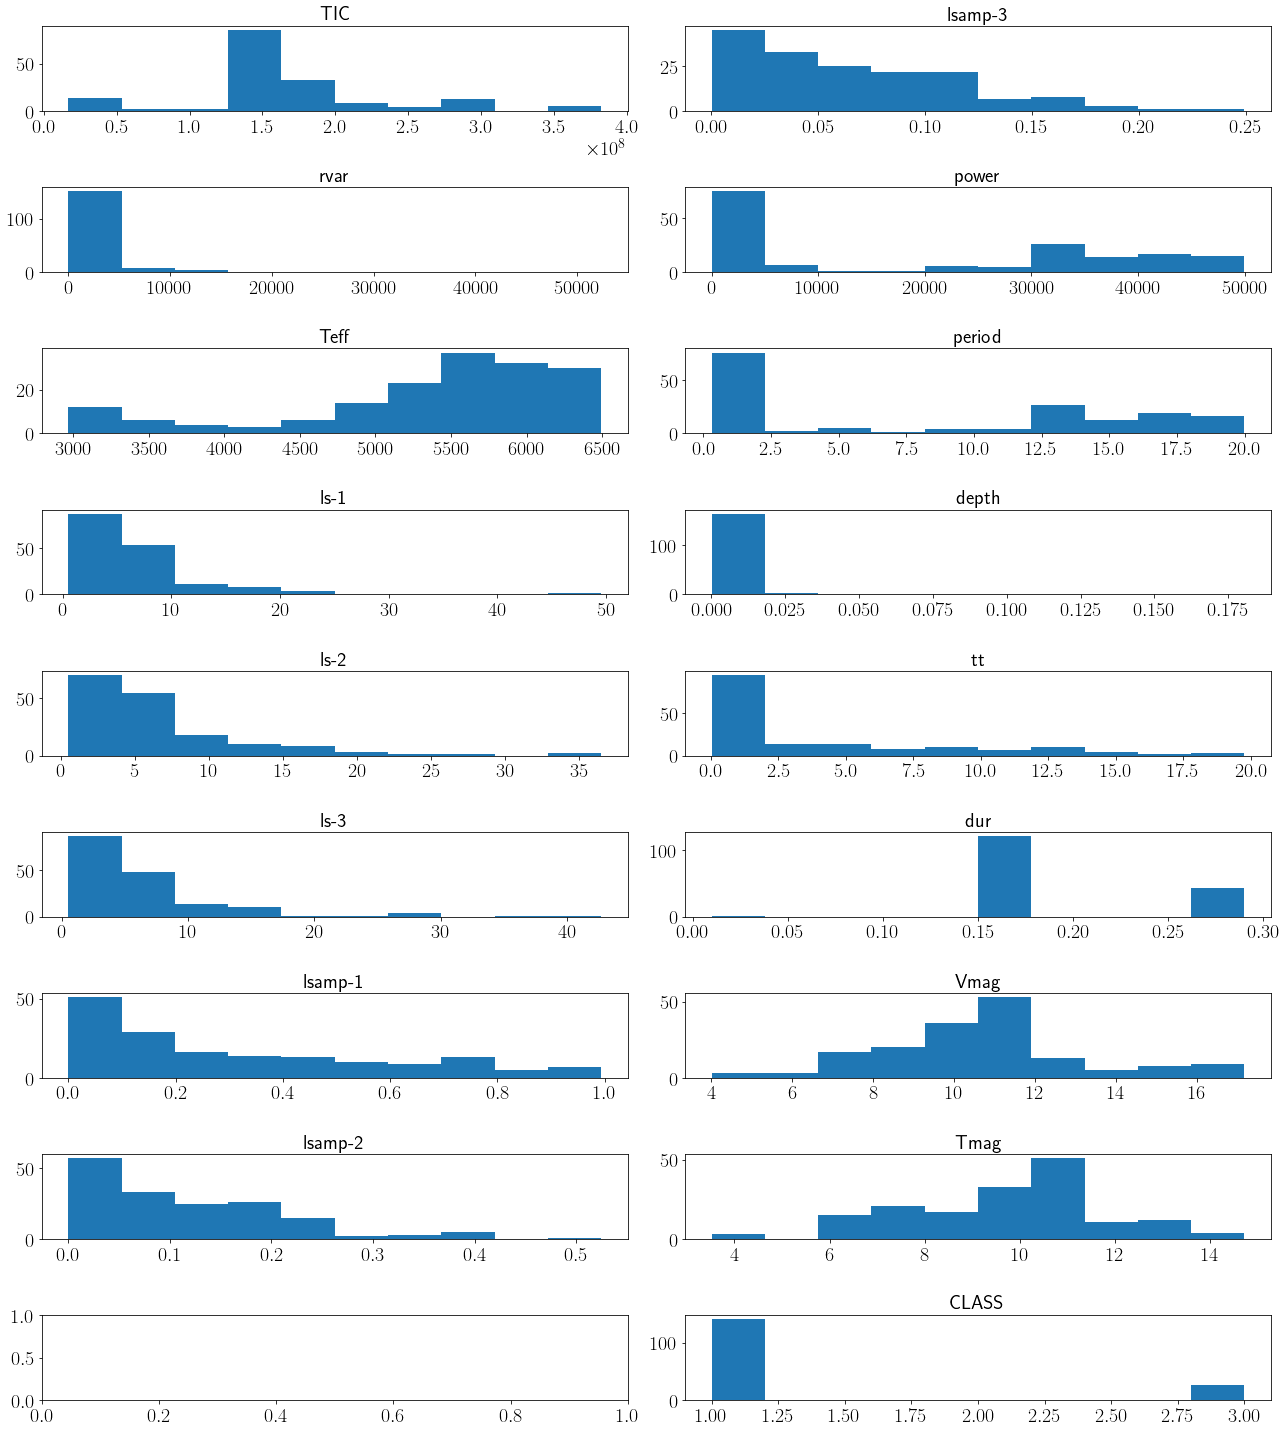

In [16]:
## explore distribution of training examples

pd.set_option('display.max_columns', 10) #go back to only show 10 columns after last 2 cells change
f, ax = plt.subplots(9,2,figsize=(18,20))
for count,col in enumerate(list(rf2_short_features.columns)):
    
    if count <8: #count % 2 ==False: #even
        ax[count,0].hist(rf2_short_features[col])
        colsplit = col.split("_")
        colname = colsplit[0]
        ax[count,0].set_title(colname,fontsize=20)
    else: #odd
        ax[count-8,1].hist(rf2_short_features[col])
        colsplit = col.split("_")
        colname = colsplit[0]
        ax[count-8,1].set_title(colname,fontsize=20)
plt.tight_layout()

In [17]:
## summarize Final info used in RF-2

#inject random number as feature
np.random.seed(seed = 11)
rf2_short_features['random'] = np.random.random(size = len(rf2_short_features))
#split training labels from data
rf2_final_labels = rf2_short_features['CLASS'].to_numpy()
rf2_final_features = rf2_short_features.drop(columns=['CLASS'])
# print('verify these match {} = {}\n'.format(len(final_labels),len(final_features)))

# print final number of training examples and which features used
print('RF-2\n----------------------------\n')
print('{} Features Used. \nThey are {}'.format(len(rf2_final_features.columns),list(rf2_final_features.columns)))
print('{} Training Examples Used.'.format(len(rf2_final_features)))
print('\n------------------------------- \nUse "rf2_final_labels" & "rf2_final_features"')

RF-2
----------------------------

17 Features Used. 
They are ['TIC', 'rvar', 'Teff', 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3', 'power_bls', 'period_bls', 'depth_bls', 'tt_bls', 'dur_bls', 'Vmag', 'Tmag', 'random']
167 Training Examples Used.

------------------------------- 
Use "rf2_final_labels" & "rf2_final_features"


In [18]:
## RF-2 model

#set variable for feature data
rf2_X = rf2_final_features.copy()
#set variable for correct labels
rf2_y = rf2_final_labels
#split data into test and training set
X_train, test_X, y_train, test_y = train_test_split(rf2_X, rf2_y, random_state = 11)
#define random forest model
rf2_model = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf2_model.fit(X_train, y_train)
# print accuracy scores
print('Test Set Accuracy:',rf2_model.score(test_X,test_y))  
print('Training Set Accuracy:', rf2_model.score(X_train,y_train))
print('Out of the Box Accuracy:',rf2_model.oob_score_)

Test Set Accuracy: 0.8809523809523809
Training Set Accuracy: 1.0
Out of the Box Accuracy: 0.88


In [19]:
## Cross Validation of RF-2

#set variable for feature data
rf2_X_CV = rf2_final_features.copy() #.reset_index(drop=True)
#set variable for correct labels
rf2_y_CV = rf2_final_labels



#input: features,labels
# divide data to train(80),test(19),validate(1)
rf2_CVpredictions = [] #collect predictions for loo - can add to df as a column b/c loo goes in order
for count,idx in enumerate(rf2_X_CV.index):
    ##get validation set
    loo_x = rf2_X_CV.iloc[count]
    loo_y = rf2_y_CV[count]
    ##remove validation data from features/labels
    x_after_loo = rf2_X_CV.drop(index = idx)
    y_after_loo = np.delete(rf2_y_CV, count)
    ##split remaining data into training & testing
    x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x_after_loo, y_after_loo, random_state = 11)
    ##setup model
    rf2_model_CV = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
    ##fit model with train data
    rf2_model_CV.fit(x_train_cv, y_train_cv)
    ##make loo into a df b/c model is picky b/c its only one example
    mydic = {'TIC':loo_x['TIC'],'rvar':loo_x['rvar'],'ls-1':loo_x['ls-1'],'ls-2':loo_x['ls-2'],
            'ls-3':loo_x['ls-3'],'lsamp-1':loo_x['lsamp-1'],'lsamp-2':loo_x['lsamp-2'],'lsamp-3':loo_x['lsamp-3'],
             'power_bls':loo_x['power_bls'],'period_bls':loo_x['period_bls'],'depth_bls':loo_x['depth_bls'],'tt_bls':loo_x['tt_bls'],'dur_bls':loo_x['dur_bls'],
            'Vmag':loo_x['Vmag'],'Tmag':loo_x['Tmag'],'Teff':loo_x['Teff'],'random':loo_x['random']}
    loo_x_df = pd.DataFrame(mydic,index=[0])
    ##predict for validate target
    validation_prediction = rf2_model_CV.predict(loo_x_df) 
    ##save predictions
    rf2_CVpredictions.append(validation_prediction[0])
    
##add to df
rf2_X_CV['prediction'] = rf2_CVpredictions
rf2_X_CV['truth'] = rf2_y_CV
#CV_LOO accuracy
rf2_correct = 0
for count,val in enumerate(rf2_X_CV['prediction'].to_numpy()):
    truth = rf2_X_CV['truth'].iloc[count]
    if val == truth:
        rf2_correct += 1
    else:
        pass
    
print((rf2_correct/len(rf2_X_CV)) *100, 'accurate for cross validation')

85.62874251497006 accurate for cross validation


depth_bls     0.249364
lsamp-3       0.086364
lsamp-2       0.085023
ls-2          0.084815
lsamp-1       0.082488
ls-1          0.064030
TIC           0.058546
ls-3          0.051673
Tmag          0.049039
Vmag          0.035884
tt_bls        0.025148
Teff          0.025123
random        0.025106
period_bls    0.023981
power_bls     0.023589
rvar          0.022134
dur_bls       0.007693
dtype: float64


No handles with labels found to put in legend.


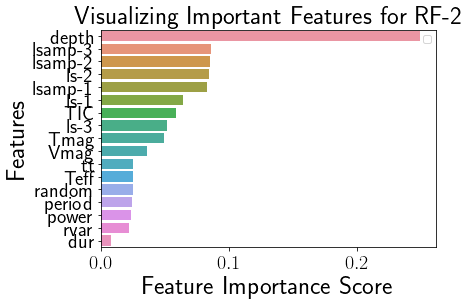

In [20]:
## feature importances

#stsci ds (DSMO) way
rf2_feature_imp = pd.Series(rf2_model.feature_importances_,index=list(rf2_X.columns)).sort_values(ascending=False)
print(rf2_feature_imp)
#fix feature names so plot can avoid latex issues
rf2_imps=[]
for i in rf2_feature_imp.index:
    i = i.split("_")
    i = i[0]
    rf2_imps.append(i)
#create a bar plot
sns.barplot(x=rf2_feature_imp, y=rf2_imps) #feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features for RF-2",fontsize=25)
plt.legend()
plt.show()

In [21]:
## make predictions on all data

#inject random number---done in RF-1
# np.random.seed(seed = 11)
# allstats['random'] = np.random.random(size = len(allstats))
#select only columns used as features
rf2_allstats_features = allstats[list(rf2_final_features.columns)]
#drop nans
all_forRF2 = rf2_allstats_features.dropna() 
#see effects of selected features if nans
rf2_nan_loss = len(rf2_allstats_features) - len(all_forRF2)
print('due to nan features lost: {} targets'.format(rf2_nan_loss))
#make predictions
rf2_predictions = rf2_model.predict(all_forRF2)
#add predicted class to df
all_forRF2['RF2predict_class'] = rf2_predictions
# merge RF2 predicitons to master data
RF2_master_data = RF1_master_data.join(all_forRF2['RF2predict_class'])

RF2_master_data

due to nan features lost: 140 targets


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,TIC,period_bls,power_bls,depth_bls,dur_bls,...,TOTsecs,LS_correct,random,RF1predict_class,RF2predict_class
0,7582633,0.301299,24.0,0.000203,0.29,...,NaN,NaN,0.180270,1.0,1.0
1,7582634,0.301299,24.0,0.000365,0.29,...,NaN,NaN,0.019475,5.0,1.0
2,7583285,0.302712,50.0,0.000313,0.29,...,NaN,NaN,0.463219,5.0,1.0
3,7585322,0.301950,36.0,0.000090,0.29,...,NaN,NaN,0.724934,5.0,1.0
4,7619197,0.300486,9.0,0.000062,0.29,...,NaN,NaN,0.420204,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
26129,349152048,13.595352,33145.0,0.000076,0.16,...,12.0,1.0,0.764213,1.0,1.0
26130,349154435,4.432229,9032.0,0.009053,0.16,...,13.0,1.0,0.634079,1.0,1.0
26131,364302118,1.345427,909.0,0.007843,0.16,...,12.0,NaN,0.314434,1.0,3.0
26132,382069441,16.470489,40711.0,0.002633,0.16,...,12.0,NaN,0.337377,1.0,1.0


In [22]:
## summarize RF-2 results proceeding to RF-3

#definitions
rf1_goodcut = (RF2_master_data['RF1predict_class']==1.0) #periodic
rf2_goodcut = (RF2_master_data['RF2predict_class']==1.0) #no transit
only_training = np.isnan(RF2_master_data['CLASS'])==False #training examples (used or not)
not_training = (np.isnan(RF2_master_data['CLASS'])==True) #unseen data
rf2_badcut = (RF2_master_data['RF2predict_class']==3.0) #transiting
rf1_badcut = (RF2_master_data['RF1predict_class']==5.0) #flat
#cuts
rf2_good_unseenpredictions = RF2_master_data[rf1_goodcut & rf2_goodcut & not_training]#passed RF1&2& is not a training exmaple
rf2_bad_unseenpredictions = RF2_master_data[rf1_goodcut & rf2_badcut & not_training] #passed RF1 & failed RF2 & is not a training example
rf2_good_allpredictions = RF2_master_data[rf1_goodcut & rf2_goodcut] #passed RF 1 & RF 2
rf2_bad_allpredictions = RF2_master_data[rf1_goodcut & rf2_badcut] #passed RF 1 & failed RF 2
#adjusting unseen total for those that passed RF-1
rf2_allpassed_rf1_total = RF2_master_data[rf1_goodcut]
rf2_unseen_total = RF2_master_data[rf1_goodcut & not_training]
print('predictions from RF2 for ALL data that passed RF-1 (including cvz/sec1415 training stars):')
print('NO TRANISTS:',len(rf2_good_allpredictions),'out of', len(rf2_allpassed_rf1_total) )
print('TRANSITS:',len(rf2_bad_allpredictions),'out of', len(rf2_allpassed_rf1_total) )
print('\npredictions from RF-2 for UNSEEN data (no training examples included whether used or not):')
print('NO TRANSITS:',len(rf2_good_unseenpredictions),'out of', len(rf2_unseen_total) )
print('TRANSITS:',len(rf2_bad_unseenpredictions),'out of', len(rf2_unseen_total) )

print('\n{} stars proceed to RF-3'.format(len(rf2_good_unseenpredictions)))

predictions from RF2 for ALL data that passed RF-1 (including cvz/sec1415 training stars):
NO TRANISTS: 8227 out of 8361
TRANSITS: 134 out of 8361

predictions from RF-2 for UNSEEN data (no training examples included whether used or not):
NO TRANSITS: 8045 out of 8166
TRANSITS: 121 out of 8166

8045 stars proceed to RF-3


# RF-3 ---------------------------------------------
## would still be useful to match these examples into master_data to see if they all would have passed rf1 & rf2 or not

In [23]:
## load data b/c these training examples are a separate df

## all stats that are McQuillan matches table
matches_table = pd.read_csv('/Volumes/Seagate-stars/SECTORS/MQmatches_allstats_14_15.csv')
## all stats from CVZ that ls-1 were verified by eye to be correct - used in original RF classifier
cvz_examples = pd.read_csv('data/good_cvz_stats_for_RF.csv')

## give a CLASS to Sec 14/15 training examples

#use rel_tol to add data to groups
using_tolerance = .15 #amount of disagreement betwn mine & MQ's Prot to still match
goodtable = matches_table[[m.isclose(matches_table['ls-1'][i],matches_table['MQ_Prot'][i],rel_tol=using_tolerance) for i in range(len(matches_table))]]
halftable = matches_table[[m.isclose(matches_table['ls-1'][i]*2,matches_table['MQ_Prot'][i],rel_tol=using_tolerance) for i in range(len(matches_table))]]
goodindices = list(goodtable.index) + list(halftable.index) #get index of rows in good/half tables
badtable = matches_table[~matches_table.index.isin(goodindices)] #select index if NOT in goodindices aka bad
# add label column to each groups table
badtable['Label'] = np.repeat(1,len(badtable))
halftable['Label'] = np.repeat(1,len(halftable)) #temp change to good to see if better precison
goodtable['Label'] = np.repeat(3,len(goodtable))
#helps keep track of how i assigned half harmonic targets
if halftable['Label'][0]==1:
    half_as = 'uses halves as BAD'
    print('----------->>>',half_as)
elif halftable['Label'][0]==2:
    half_as = 'uses halves as HALF'
    print('----------->>>',half_as)
elif halftable['Label'][0]==3:
    half_as = 'uses halves as GOOD'
    print('----------->>>',half_as)
else:
    half_as = '----------->>> Something Went Wrong <<<----------- '
    print(half_as)
# make one table 
mq_examples = pd.concat([goodtable,halftable,badtable])

## add in CVZ examples to Sec 14/15 training examples

#add in TEFF column
mytics = cvz_examples['TIC'].to_numpy() #get cvz tics
catalog_data = Catalogs.query_criteria(catalog='Tic',ID=mytics) #get tic catalog for cvz tics
catalog_df = catalog_data.to_pandas() #make a df for merging
catalog_teff = catalog_df[['plx','GAIAmag','ID','Teff']] #isolate columns wanted
catalog_teff["ID"] = pd.to_numeric(catalog_teff["ID"]) #make int to match data types in next line
CVZnTIC = pd.merge(cvz_examples,catalog_teff ,left_on='TIC',right_on='ID')
cvz_examples = CVZnTIC.drop('ID',1)
## combine all training examples
mydfs = [mq_examples,cvz_examples]
rf3_examples_preteff = pd.concat(mydfs)
#remove high teff from this part of train set
rf3_examples = rf3_examples_preteff[rf3_examples_preteff['Teff']<=6500]
rf3_teff_loss = len(rf3_examples_preteff) - len(rf3_examples)
print('orig. CVZ examples:',len(cvz_examples))
print('orig. Sec14/15 examples:',len(mq_examples))
print('Lost {} to Teff cut'.format(rf3_teff_loss))
###########################

print('TOTAL training examples BEFORE giant drop:',len(rf3_examples))

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

----------->>> uses halves as BAD
orig. CVZ examples: 95
orig. Sec14/15 examples: 226
Lost 8 to Teff cut
TOTAL training examples BEFORE giant drop: 313


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'gaiaqflag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A valu

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


removed 35 giants in examples
NEW TOTAL training examples: 278

Will use the pink & grey points so both need to be below red line


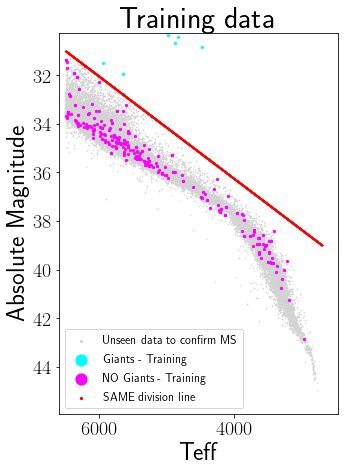

In [24]:
##remove giants

## add Abs_Mag column & find division line ---to remove giants from training data
t_abs_GAIAmag = []
t_teffs =[]
for plx,mag,temp in rf3_examples[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    t_abs_GAIAmag.append(newmag)
    t_teffs.append(temp)
#add to df
rf3_examples['GAIA_AbsMag'] = t_abs_GAIAmag

#determine division line params
d_pt1 = [6500,31]
d_pt2 = [2700,39]
d_m = slope(d_pt1[0],d_pt2[0],d_pt1[1],d_pt2[1])
d_b = get_b(d_m,d_pt1[0],d_pt1[1])
#create arrays for line
d_xarr = np.arange(d_pt2[0],d_pt1[0],1)
d_yarr = [d_m*x + d_b for x in d_xarr]

##removing giants from training sample & verfiy unseen data doesnt have any

#do cut along division line for features 
compare_values = [d_m*x + d_b for x in rf3_examples['Teff'].to_numpy()] #ABSmagnitude value on the red line at star's teff
features_nogiants = rf3_examples[[rf3_examples['GAIA_AbsMag'].to_numpy()[i] > compare_values[i] for i in range(len(compare_values))]]
features_giantsonly = rf3_examples[[rf3_examples['GAIA_AbsMag'].to_numpy()[i] <= compare_values[i] for i in range(len(compare_values))]]
#plot
plt.figure(figsize=(5,7))
plt.scatter(allstats['Teff'].to_numpy(),allstats['GAIA_AbsMag'].to_numpy(),s=.2,label='Unseen data to confirm MS',color='lightgrey')
plt.scatter(features_giantsonly['Teff'].to_numpy(),features_giantsonly['GAIA_AbsMag'].to_numpy(),s=5,label='Giants - Training',color='cyan')
plt.scatter(features_nogiants['Teff'].to_numpy(),features_nogiants['GAIA_AbsMag'].to_numpy(),s=5,label='NO Giants - Training',color='magenta')
plt.scatter(d_xarr,d_yarr,color='r',s=.2,label='SAME division line')
plt.legend(fontsize='large',markerscale=5)
plt.ylabel('Absolute Magnitude');plt.xlabel('Teff');
plt.xlim(max(allstats['Teff'].to_numpy())+100,min(allstats['Teff'].to_numpy())-300)
plt.ylim(max(allstats['GAIA_AbsMag'].to_numpy())+1,min(allstats['GAIA_AbsMag'].to_numpy())-1);
plt.title('Training data',fontsize=30);
print('removed {} giants in examples'.format( len(rf3_examples) - len(features_nogiants) ) )
print('NEW TOTAL training examples: {}'.format(len(features_nogiants)))
print('\nWill use the pink & grey points so both need to be below red line')

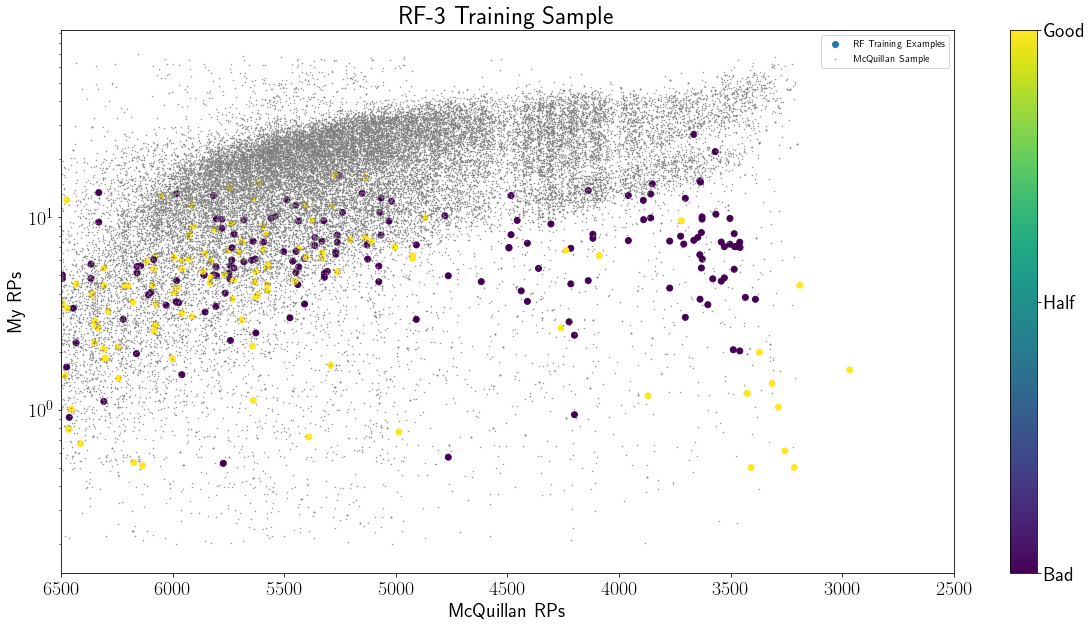

In [25]:
## check distribution of examples
from matplotlib import cm

fig, ax = plt.subplots(figsize=(20,10))

cax = plt.scatter(features_nogiants['Teff'].to_numpy(),features_nogiants['ls-1'].to_numpy(),c=features_nogiants['Label'].to_numpy(),label='RF Training Examples')
ax.scatter(mqdata['TEMP'],mqdata['ROTATION_PERIOD'].to_numpy(),color='grey',s=.2,rasterized=True,label='McQuillan Sample')
ax.set_title('RF-3 Training Sample',fontsize=25)
ax.legend()
ax.set_xlabel('McQuillan RPs',fontsize=20);plt.ylabel('My RPs',fontsize=20);
# ax.set_xlim(8500,2500);
ax.set_xlim(6500,2500);ax.set_yscale('log')
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[1,2, 3])
cbar.ax.set_yticklabels(['Bad','Half',  'Good']);  # vertically oriented colorbar

In [26]:
## select features


#note cant use bls b/c cvz examples dont have those stats
rf3_features_list = ['TIC', 'Sector', 'rvar', 'ls-1', 'ls-2', 'ls-3', 
                     'lsamp-1', 'lsamp-2', 'lsamp-3', 'Teff','Label']

#select features
rf3_short_features_nans = features_nogiants[rf3_features_list]
#remove any nans in the final features
rf3_short_features = rf3_short_features_nans.dropna()
#see effect of features on number of examples
rf3_nan_exs_loss = len(rf3_short_features_nans) - len(rf3_short_features)
print('{} examples lost with these features'.format(rf3_nan_exs_loss))
#check final distribution for possible problems
rf3_short_features.describe(include='all')

0 examples lost with these features


,TIC,Sector,rvar,ls-1,ls-2,...,lsamp-1,lsamp-2,lsamp-3,Teff,Label
count,2.780000e+02,278.000000,278.000000,278.000000,278.000000,...,278.000000,278.000000,278.000000,278.000000,278.000000
mean,1.943771e+08,14.374101,65.342996,6.186952,5.907980,...,0.180473,0.077213,0.043014,5180.027734,1.848921
std,9.751597e+07,0.414509,91.680558,3.834533,4.263581,...,0.225609,0.089751,0.051508,983.735429,0.990304
min,2.653813e+07,14.000000,0.002104,0.501684,0.500644,...,0.000644,0.000598,0.000430,2967.000000,1.000000
25%,1.391185e+08,14.000000,6.127422,3.636276,2.976958,...,0.010428,0.005683,0.003616,4318.987500,1.000000
50%,1.673441e+08,14.250000,43.054651,5.560647,5.331147,...,0.064154,0.034815,0.022053,5468.180000,1.000000
75%,2.710402e+08,14.500000,73.145288,7.850140,7.839556,...,0.274884,0.130797,0.064348,5925.325000,3.000000
max,4.248650e+08,15.000000,641.614746,26.905754,39.484719,...,0.956839,0.451356,0.287187,6494.000000,3.000000


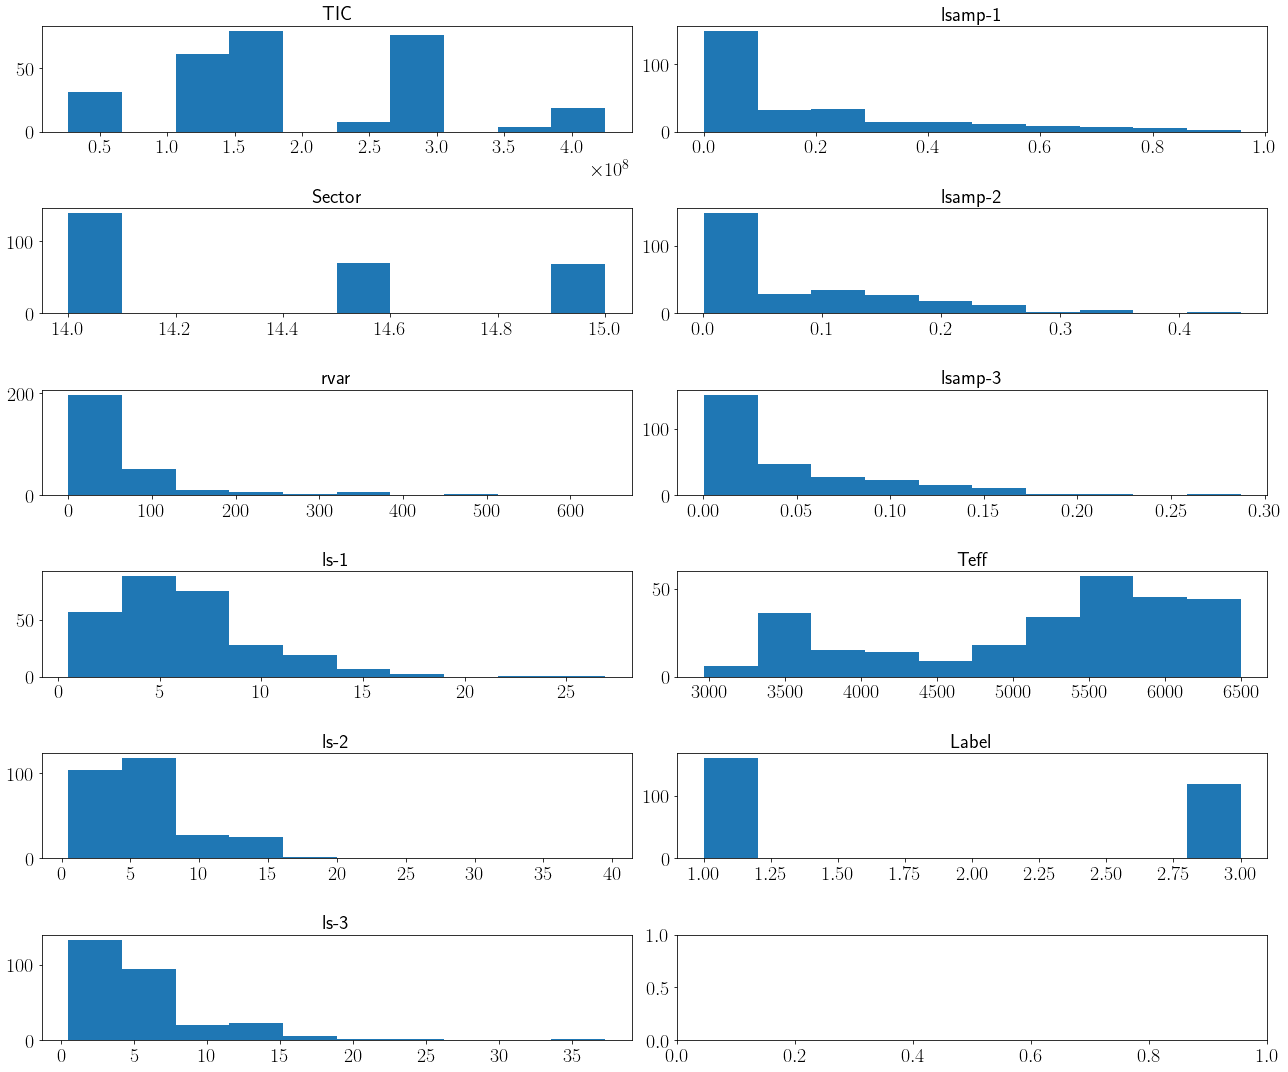

In [27]:
## explore distribution of training examples' features

f, ax = plt.subplots(6,2,figsize=(18,15))
for count,col in enumerate(list(rf3_short_features.columns)):    
    if count <6: #count % 2 ==False: #even
        ax[count,0].hist(rf3_short_features[col])
        ax[count,0].set_title(col,fontsize=20)
    else: #odd
        ax[count-6,1].hist(rf3_short_features[col])
        ax[count-6,1].set_title(col,fontsize=20)
plt.tight_layout()

In [29]:
## summarize Final info used in RF-3

#inject random number as feature
np.random.seed(seed = 11)
rf3_short_features['random'] = np.random.random(size = len(rf3_short_features))
#split training labels from data
rf3_final_labels = rf3_short_features['Label'].to_numpy()
rf3_final_features = rf3_short_features.drop(columns=['Label'])
#see training examples source
short1 = matches_table[['TIC','Sector','MQ_Prot']] #select needed MQ cols - she has no giants intrinsicly
merge1 = rf3_short_features.merge(short1, on = ['TIC','Sector']) #match targets to mq
mq_only = len(merge1) #only those that match with mq table
cvz_only = len(rf3_final_features) - mq_only #total examples minus those that match with mq table
# print final number of training examples and which features used
print('RF-2\n----------------------------\n')
print('{} Features Used. \nThey are {}'.format(len(rf3_final_features.columns),list(rf3_final_features.columns)))
print('{} Training Examples Used. {} from CVZ {} from MQ'.format(len(rf3_final_features), cvz_only, mq_only))
print('\nLabels for this model include {}-Good; {}-Bad; {}-Half harmonics'.format(len(rf3_short_features[rf3_short_features['Label'].to_numpy()==3]),len(rf3_short_features[rf3_short_features['Label'].to_numpy()==1]),len(rf3_short_features[rf3_short_features['Label'].to_numpy()==2])))
print(half_as)
print('\n------------------------------- \nUse "rf3_final_labels" & "rf3_final_features"')



RF-2
----------------------------

11 Features Used. 
They are ['TIC', 'Sector', 'rvar', 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3', 'Teff', 'random']
278 Training Examples Used. 70 from CVZ 208 from MQ

Labels for this model include 118-Good; 160-Bad; 0-Half harmonics
uses halves as BAD

------------------------------- 
Use "rf3_final_labels" & "rf3_final_features"


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


Test Set Accuracy: 0.9
Training Set Accuracy: 0.9711538461538461
Out of the Box Accuracy: 0.8942307692307693
Confusion Matrix:
 [[35  1]
 [ 6 28]]


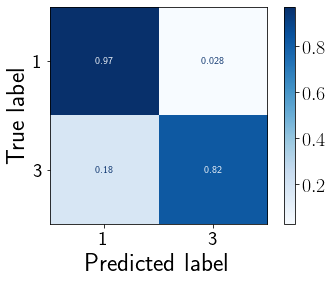

In [30]:
## RF-3 model

#set variable for feature data
rf3_x = rf3_final_features 
#set variable for correct labels
rf3_y = rf3_final_labels
#split data into test and training set
x_train, test_x, y_train, test_y = train_test_split(rf3_x, rf3_y, random_state = 11)
#define random forest model
rf3_model = RandomForestClassifier(n_estimators = 200,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf3_model.fit(x_train, y_train)
## print accuracy scores
print('Test Set Accuracy:',rf3_model.score(test_x, test_y))  
print('Training Set Accuracy:', rf3_model.score(x_train, y_train))
print('Out of the Box Accuracy:',rf3_model.oob_score_)
## confusion matrix of test set
test_predictions = rf3_model.predict(test_x)# have fit model predict labels for previously unseen data
conf_mat = confusion_matrix(test_y, test_predictions)# makes the matrix
print('Confusion Matrix:\n',conf_mat)#see matrix raw numbers
#plot matrix
disp = plot_confusion_matrix(rf3_model, test_x, test_y,
cmap=plt.cm.Blues, normalize='true')

In [31]:
## Cross Validation

#set variable for feature data
rf3_X_CV = rf3_final_features.reset_index(drop=True)#so index is in order and old index isnt added as a column 
#set variable for correct labels
rf3_y_CV = rf3_final_labels

rf3_CVpredictions = [] #collect predictions for loo - can add to df as a column b/c loo goes in order
for count,idx in enumerate(range(len(rf3_X_CV))):
    ##get validation set
    loo_x = rf3_X_CV.iloc[idx]
    loo_y = rf3_y_CV[idx]
    ##remove validation data from features/labels
    x_after_loo = rf3_X_CV.drop(index = idx)
    y_after_loo = np.delete(rf3_y_CV, idx)
    ##split remaining data into training & testing
    x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x_after_loo, y_after_loo, random_state = 11)
    ##setup model
    rf3_model_CV = RandomForestClassifier(n_estimators = 100,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
    ##fit model with train data
    rf3_model_CV.fit(x_train_cv, y_train_cv)
    mydic = {'TIC':loo_x['TIC'],'Sector':loo_x['Sector'],'rvar':loo_x['rvar'],'ls-1':loo_x['ls-1'],'ls-2':loo_x['ls-2'],
            'ls-3':loo_x['ls-3'],'lsamp-1':loo_x['lsamp-1'],'lsamp-2':loo_x['lsamp-2'],'lsamp-3':loo_x['lsamp-3'],
                    'Teff':loo_x['Teff'],'random':loo_x['random']}    
    loo_x_df = pd.DataFrame(mydic,index=[0])
    ##predict for validate target
    validation_prediction = rf3_model_CV.predict(loo_x_df) 
    ##save predictions
    rf3_CVpredictions.append(validation_prediction[0])
    
##add to df
rf3_X_CV['prediction'] = rf3_CVpredictions
rf3_X_CV['truth'] = rf3_y_CV

#CV_LOO accuracy
rf3_correct = 0
for count,val in enumerate(rf3_X_CV['prediction'].to_numpy()):
    truth = rf3_X_CV['truth'].iloc[count]
    if val == truth:
        rf3_correct += 1
    else:
        pass
    
print((rf3_correct/len(rf3_X_CV)) *100, 'accurate for cross validation')

89.20863309352518 accurate for cross validation


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1145: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


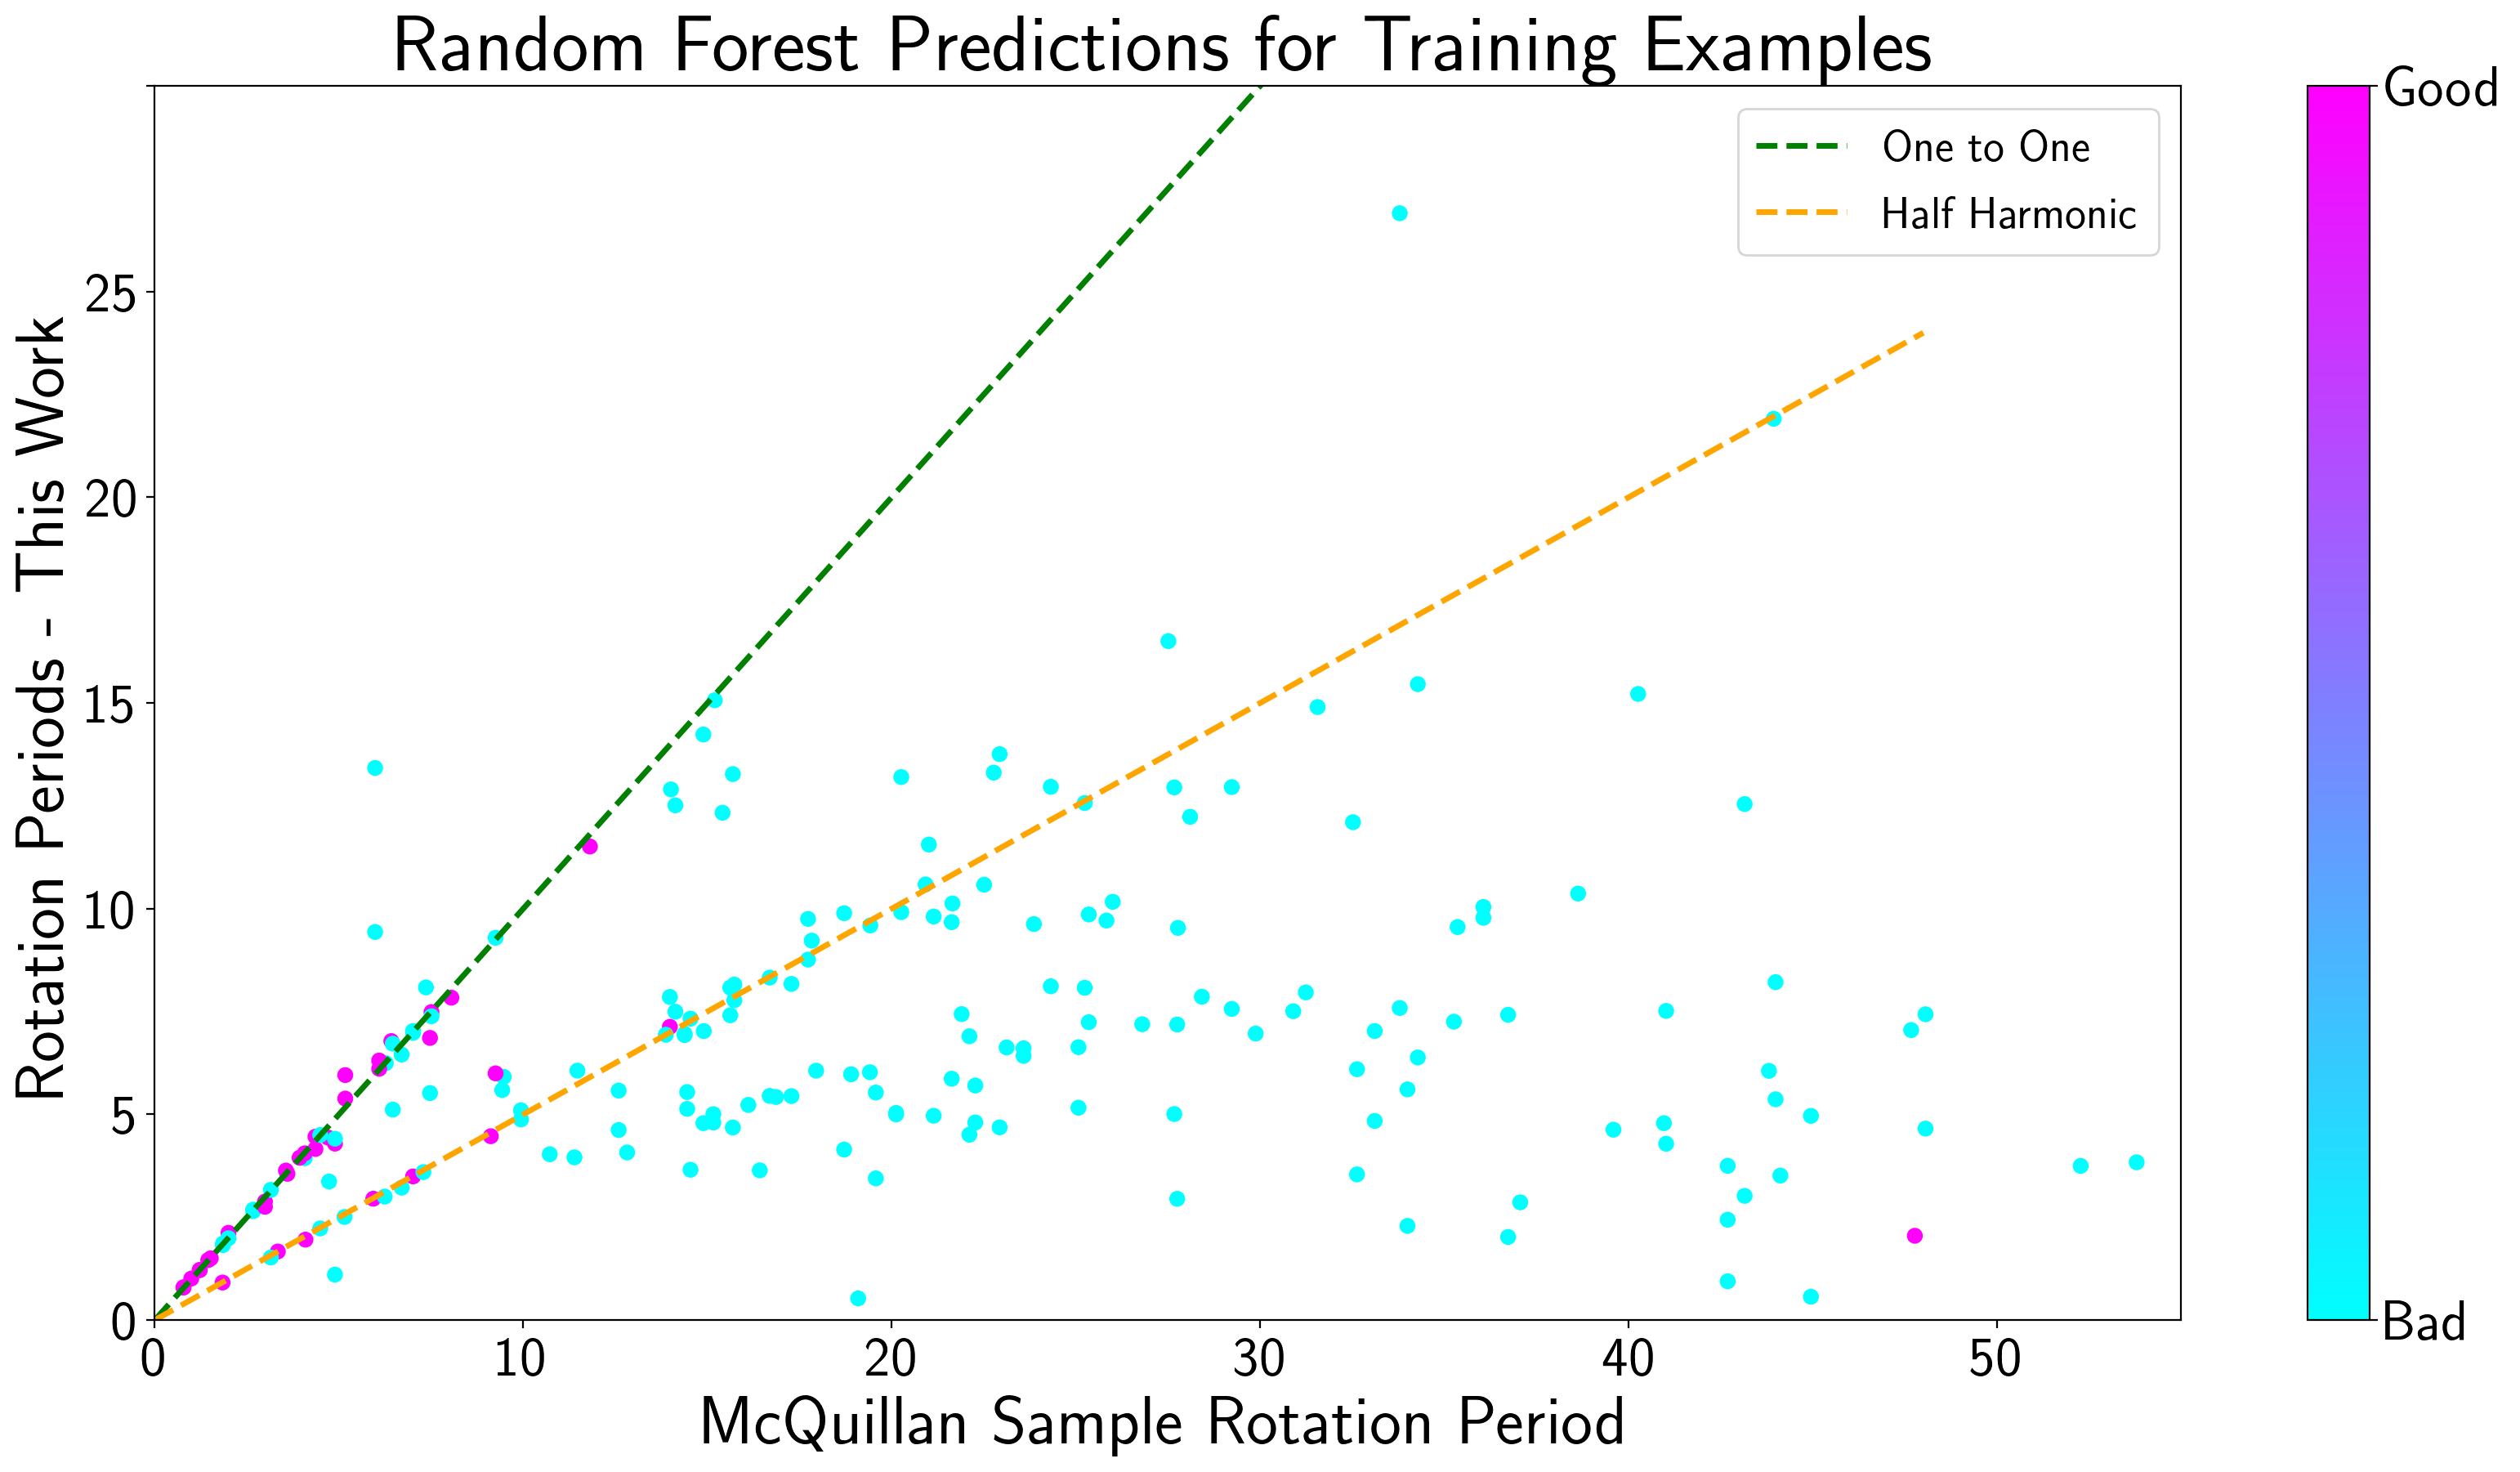

In [32]:
## plot loo_cv predictions for MQ matches (no true Prot for CVZ) to help see what half harmonics were predicted as

#add in MQ Prot values for plotting purposes
# header_list = ['TIC','KIC','MQ_Prot']
cmatch = matches_table[['TIC','Sector','MQ_Prot']]
# cmatch = pd.read_csv('data/useful_catalogs/tics_kics_mcq_rot.txt',delimiter=' ',names=header_list)
mq_predictions = rf3_X_CV.merge(cmatch, on = ['TIC','Sector']) #left_on='TIC',right_on='TIC')

if half_as == 'uses halves as BAD':
    from matplotlib import cm

    fig, ax = plt.subplots(figsize=(20,10),dpi=200)
    #lines to guide eye
    ax.plot(np.arange(0,50,2),np.arange(0,50,2),ls='--',lw=2.5,color='g',label='One to One')
    ax.plot(np.arange(0,50,2),np.arange(0,25,1),ls='--',lw=2.5,color='orange',label='Half Harmonic')
    #Prot measures
    cax = ax.scatter(mq_predictions['MQ_Prot'].to_numpy(),mq_predictions['ls-1'].to_numpy(),cmap=cm.cool, c =mq_predictions['prediction'].to_numpy())
    ax.legend(fontsize=20)
    ax.set_title('Random Forest Predictions for Training Examples',fontsize=35)
    ax.set_xlabel('McQuillan Sample Rotation Period',fontsize=30);plt.ylabel('Rotation Periods - This Work',fontsize=30);
    ax.set_ylim(0,30),ax.set_xlim(0,55);
    #makes the labels bigger but idk how to make x-axis go by 5s w/o putting a wrong label completely
    ax.set_xticklabels(np.arange(0,60,10),fontsize=25)
    ax.set_yticklabels(np.arange(0,30,5),fontsize=25)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    cbar = fig.colorbar(cax, ticks=[1, 3],cmap=cm.cool)
    cbar.ax.set_yticklabels(['Bad',  'Good'],fontsize=25);  # vertically oriented colorbar

    # plt.savefig('data/talk_plots/RF_TrainingSet_predictions.jpg')
else:
    pass

In [33]:
#accuracy calclation

acc = 0; inacc=0; wrongs=0; rights=0; total_goods=0; total_bads=0;false_positives=0;false_negatives =0
for idx in range(len(mq_predictions)):
    true_cat = mq_predictions['truth'].iloc[idx]
    predict_cat = mq_predictions['prediction'].iloc[idx]
    if true_cat == predict_cat:
        acc +=1
        if true_cat == 1: #both are bad
            wrongs +=1
            #false_negatives +=1
        else: #both good
            rights +=1
            
    else:
        inacc +=1
        if predict_cat == 1: #predicted bad when really was good
            false_negatives +=1
        else: # predicted good when realy was bad
            false_positives +=1
            
    if true_cat == 3:
        total_goods += 1 #total number of good truths
    else:
        total_bads +=1 #total number of bad truths
        
overall_acc = acc/len(mq_predictions) * 100
overall_inacc = inacc/len(mq_predictions) * 100
print('Overall Percent Accurate:',overall_acc)
print('Overall Percent Inaccurate:',overall_inacc)
print('Sanity Check Sum:', overall_inacc + overall_acc)
print('\nBreakdown of Overall Accuracy')
print('Good Accuracy:',rights/total_goods *100)
print('Bad Accuracy:', wrongs/total_bads * 100)
print('False Positive Percentage:',false_positives/len(mq_predictions) * 100)
print('False Negative Percentage:',false_negatives/len(mq_predictions) * 100)

Overall Percent Accurate: 85.57692307692307
Overall Percent Inaccurate: 14.423076923076922
Sanity Check Sum: 99.99999999999999

Breakdown of Overall Accuracy
Good Accuracy: 56.25
Bad Accuracy: 94.375
False Positive Percentage: 4.326923076923077
False Negative Percentage: 10.096153846153847


No handles with labels found to put in legend.


rvar       0.281071
lsamp-1    0.162882
Sector     0.114647
lsamp-2    0.104213
lsamp-3    0.087423
ls-2       0.072135
ls-1       0.047762
Teff       0.043763
ls-3       0.037661
TIC        0.033207
random     0.015235
dtype: float64


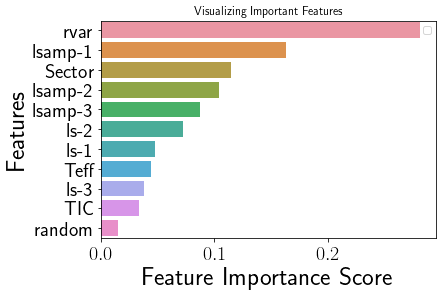

In [34]:
## feature importance

#stsci ds (DSMO) way
rf3_feature_imp = pd.Series(rf3_model.feature_importances_,index=list(rf3_x.columns)).sort_values(ascending=False)
print(rf3_feature_imp)
#fix feature names so plot can avoid latex issues
rf3_imps=[]
for i in rf3_feature_imp.index:
    if i[-4::]=='orig':
        i = i.split("_")
        i = i[0]
    else:
        i = i
    rf3_imps.append(i)
#create a bar plot
sns.barplot(x=rf3_feature_imp, y=rf3_imps) #feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [35]:
## make predictions

#prep for rf3 by selecting features used
rf3_allstats_features = allstats[list(rf3_final_features.columns)]
#drop nans
all_forRF3 = rf3_allstats_features.dropna() 
#see effects of selected features if nans
rf3_nan_loss = len(rf3_allstats_features) - len(all_forRF3)
print('due to nan features lost: {} targets'.format(rf3_nan_loss))
#make predictions
rf3_predictions = rf3_model.predict(all_forRF3)
#add predicted class to df
all_forRF3['RF3predict_class'] = rf3_predictions
# merge RF3 predicitons to master data
RF3_master_data = RF2_master_data.join(all_forRF3['RF3predict_class'])

RF3_master_data

due to nan features lost: 214 targets


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,TIC,period_bls,power_bls,depth_bls,dur_bls,...,LS_correct,random,RF1predict_class,RF2predict_class,RF3predict_class
0,7582633,0.301299,24.0,0.000203,0.29,...,NaN,0.180270,1.0,1.0,1.0
1,7582634,0.301299,24.0,0.000365,0.29,...,NaN,0.019475,5.0,1.0,1.0
2,7583285,0.302712,50.0,0.000313,0.29,...,NaN,0.463219,5.0,1.0,1.0
3,7585322,0.301950,36.0,0.000090,0.29,...,NaN,0.724934,5.0,1.0,1.0
4,7619197,0.300486,9.0,0.000062,0.29,...,NaN,0.420204,5.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
26129,349152048,13.595352,33145.0,0.000076,0.16,...,1.0,0.764213,1.0,1.0,NaN
26130,349154435,4.432229,9032.0,0.009053,0.16,...,1.0,0.634079,1.0,1.0,NaN
26131,364302118,1.345427,909.0,0.007843,0.16,...,NaN,0.314434,1.0,3.0,NaN
26132,382069441,16.470489,40711.0,0.002633,0.16,...,NaN,0.337377,1.0,1.0,NaN


In [36]:
## summarize RF-2 results proceeding to RF-3

#definitions
rf1_goodcut = (RF3_master_data['RF1predict_class']==1.0) #periodic
rf2_goodcut = (RF3_master_data['RF2predict_class']==1.0) #no transit
rf3_goodcut = (RF3_master_data['RF3predict_class']==3.0) #good Prot
rf3_badcut = (RF3_master_data['RF3predict_class']==1.0) #bad Prot
rf2_badcut = (RF3_master_data['RF2predict_class']==3.0) #transiting
rf1_badcut = (RF3_master_data['RF1predict_class']==5.0) #flat
#these arent really true b/c of mq matches that i need to note are examples
only_training = np.isnan(RF3_master_data['CLASS'])==False #training examples (used or not)
not_training = (np.isnan(RF3_master_data['CLASS'])==True) #unseen data

#cuts
rf3_good_unseenpredictions = RF3_master_data[rf1_goodcut & rf2_goodcut & rf3_goodcut &not_training]#passed RF1&2&3 & is not a training exmaple
rf3_bad_unseenpredictions = RF3_master_data[rf1_goodcut & rf2_goodcut & rf3_badcut & not_training] #passed RF1&2 but failed RF3 & is not a training example
rf3_good_allpredictions = RF3_master_data[rf1_goodcut & rf2_goodcut & rf3_goodcut] #passed RF 1&2&3
rf3_bad_allpredictions = RF3_master_data[rf1_goodcut & rf2_goodcut & rf3_badcut] #passed RF 1&2 but failed RF 3
#adjusting unseen total for those that passed RF-1
rf3_allpassed_rf1n2_total = RF3_master_data[rf1_goodcut & rf2_goodcut]
rf3_unseen_total = RF3_master_data[rf1_goodcut & rf2_goodcut & not_training]
print('predictions from RF3 for ALL data that passed RF-1 & RF-2 (including cvz/sec1415 training stars):')
print('GOOD:',len(rf3_good_allpredictions),'out of', len(rf3_allpassed_rf1n2_total) )
print('BAD:',len(rf3_bad_allpredictions),'out of', len(rf3_allpassed_rf1n2_total) )
print('\npredictions from RF-3 for UNSEEN data (no training examples included whether used or not):')
print('GOOD:',len(rf3_good_unseenpredictions),'out of', len(rf3_unseen_total) )
print('BAD:',len(rf3_bad_unseenpredictions),'out of', len(rf3_unseen_total) )

print('\n{} stars predicted good from entire pipeline'.format(len(rf3_good_allpredictions)))

predictions from RF3 for ALL data that passed RF-1 & RF-2 (including cvz/sec1415 training stars):
GOOD: 1796 out of 8227
BAD: 6293 out of 8227

predictions from RF-3 for UNSEEN data (no training examples included whether used or not):
GOOD: 1762 out of 8045
BAD: 6283 out of 8045

1796 stars predicted good from entire pipeline


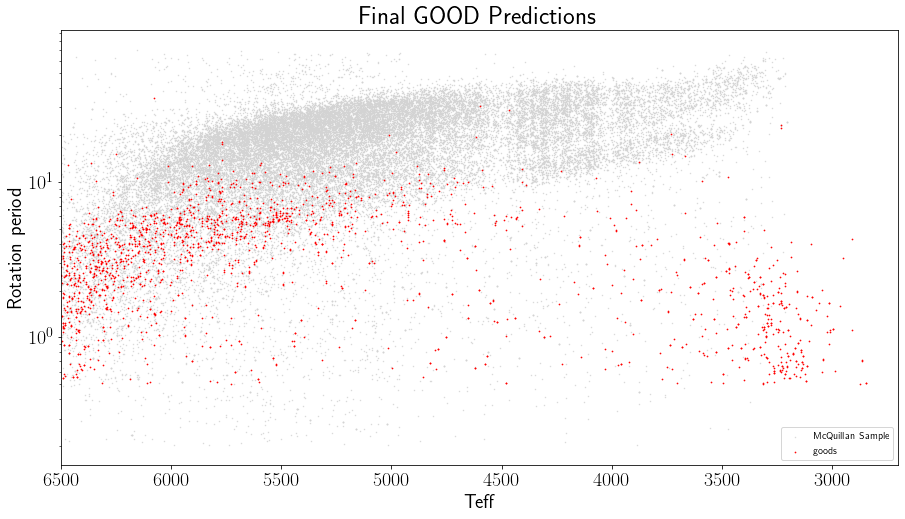

In [37]:
## final plot of good periods

myxs = rf3_good_allpredictions['Teff'].to_numpy()
myys = rf3_good_allpredictions['ls-1'].to_numpy()

f =plt.figure(figsize=(15,8))
plt.scatter(mqdata['TEMP'],mqdata['ROTATION_PERIOD'].to_numpy(),color='lightgrey',s=.2,rasterized=True,label='McQuillan Sample')
plt.scatter(myxs,myys,s=.5,label='goods',color='r')
plt.ylabel('Rotation period',fontsize=20); plt.xlabel('Teff',fontsize=20)
plt.title('Final GOOD Predictions',fontsize=25)
plt.legend()
plt.yscale('log')
plt.xlim(6500,2700);

In [ ]:
#tests mergeing matches table data into allstats---still doesn't work well

#first add class column to matches
# matches_table['CLASS'] ==n/m b/c need to know if a good match or not, wont know til post merge
#n/m this is too much extra work & still not working
# df1 = allstats
# df2 = matches_table[['TIC','Sector', 'MQ_Prot']]
# # df2.rename(columns={"KIC_y": "KIC"}))
# df3 = pd.merge(df1,df2,how='right', on=['TIC','Sector'])
# df3
# allstats_extracols = ['GAIA_AbsMag', 'CLASS', 'TOTsecs', 'LS_correct', 'random']
# matches_extracols = ['KIC_y', 'MQ_Prot']